In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


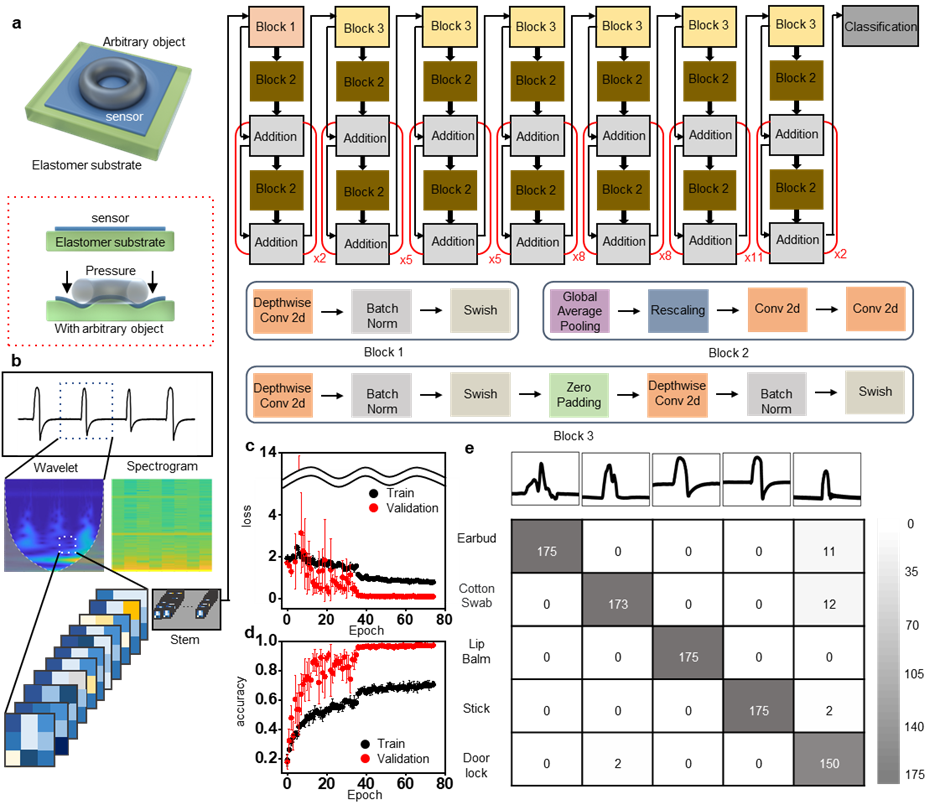

Unzip zipfile

In [ ]:
!unzip gdrive/MyDrive/벤딩_crossvalidation/all_cross_validation.zip

## import 함수

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms



import numpy as np

import math

from itertools import chain as ichain

torch.set_printoptions(linewidth=120)

In [ ]:
device = torch.device('cuda')  if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == torch.device('cuda') :
    torch.cuda.manual_seed_all(777)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:

from math import ceil
import torch
from torch.utils.data import DataLoader
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
    
torch.cuda.is_available()

True

In [ ]:
torch.backends.cudnn.benchmark = True

# Batch_size define

In [ ]:
batch_size = 8
test_batch_size = 35
num_workers = 4
val_batch_size = 25

#Rand augment

In [ ]:
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img

In [ ]:
_IMAGENET_PCA = {
    'eigval': [0.2175, 0.0188, 0.0045],
    'eigvec': [
        [-0.5675,  0.7192,  0.4009],
        [-0.5808, -0.0045, -0.8140],
        [-0.5836, -0.6948,  0.4203],
    ]
}

# Dataset,Dataloader

In [ ]:
transform_train = transforms.Compose([
            transforms.RandomResizedCrop(600, scale=(0.08, 1.0), interpolation=Image.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(
                brightness=0.4,
                contrast=0.4,
                saturation=0.4,
            ),
            transforms.ToTensor(),
            Lighting(0.1, _IMAGENET_PCA['eigval'], _IMAGENET_PCA['eigvec']),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

transform_test = transforms.Compose([
    transforms.Resize(600, interpolation=Image.BICUBIC),
    transforms.CenterCrop(600),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train.transforms.insert(0, RandAugment(2, 5)) # 7,10은 변수


wavelet_train_loader = []
wavelet_val_loader = []

test_set = torchvision.datasets.ImageFolder(f'data/e_sensor_test', transform=transform_test)

for dir in ['cross_validation_1', 'cross_validation_2', 'cross_validation_3', 'cross_validation_4', 'cross_validation_5']:
    train_set = torchvision.datasets.ImageFolder(f'data/{dir}/wavelet/train', transform=transform_train)
    val_set = torchvision.datasets.ImageFolder(f'data/{dir}/wavelet/val', transform=transform_test)

    wavelet_train_loader.append(DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers, drop_last =True ,pin_memory=True))


    wavelet_val_loader.append(DataLoader(
        val_set,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers, pin_memory=True))


wavelet_test_loader = DataLoader(
        test_set,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers, pin_memory=True)

spectrum_train_loader = []
spectrum_val_loader = []

test_set = torchvision.datasets.ImageFolder(f'data/spec_test', transform=transform_test)
spectrum_test_loader = DataLoader(
        test_set,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers, pin_memory=True)


for dir in ['cross_validation_1', 'cross_validation_2', 'cross_validation_3', 'cross_validation_4', 'cross_validation_5']:
    train_set = torchvision.datasets.ImageFolder(f'data/{dir}/spectrum/train', transform=transform_train)
    val_set = torchvision.datasets.ImageFolder(f'data/{dir}/spectrum/val', transform=transform_test)

    spectrum_train_loader.append(DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers, drop_last =True ,pin_memory=True))


    spectrum_val_loader.append(DataLoader(
        val_set,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers, pin_memory=True))



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

# Main train Function

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F
import time


def optimization_step(model, loss, data1, optimizer):
    """Make forward pass and update model parameters with gradients."""
    x_batch1, y_batch1 = data1


    # forward pass
    # compute output
    x_batch1, y_batch1 = x_batch1.to(device), y_batch1.to(device)
    logits = model(x_batch1)

    # compute logloss
    loss_value = loss(logits, y_batch1)
    batch_loss = loss_value.item()

    # compute accuracies

    pred = F.softmax(logits, dim=1)
    batch_accuracy, batch_top5_accuracy = _accuracy(y_batch1, pred, top_k=(1, 3))

    # compute gradients
    optimizer.zero_grad()
    loss_value.backward()

    # update params
    optimizer.step()

    return batch_loss, batch_accuracy, batch_top5_accuracy


def train(name, model, loss, optimization_step_fn,
          train_iterator1, val_iterator, n_epochs=30,
          patience=10, threshold=0.01, lr_scheduler=None):
    """
    Train 'model' by minimizing 'loss' using 'optimization_step_fn'
    for parameter updates.
    """

    # collect losses and accuracies here
    all_losses = []
    best_accuracy = 0
    running_loss = 0.0
    running_accuracy = 0.0
    running_top5_accuracy = 0.0
    n_steps = 0
    start_time = time.time()
    model.train()

    for epoch in range(0, n_epochs):
  
        # main training loop
        for data1 in train_iterator1:


            batch_loss, batch_accuracy, batch_top5_accuracy = optimization_step_fn(
                model, loss, data1
            )
            running_loss += batch_loss
            running_accuracy += batch_accuracy
            running_top5_accuracy += batch_top5_accuracy
            n_steps += 1
        # evaluation
            
        model.eval()
        test_loss, test_accuracy, test_top5_accuracy = _evaluate(
            model, loss, val_iterator
        )


        # collect evaluation information and print it
        all_losses += [(
            epoch,
            running_loss/n_steps, test_loss,
            running_accuracy/n_steps, test_accuracy,
            running_top5_accuracy/n_steps, test_top5_accuracy
        )]
        print('{0}  {1:.3f} {2:.3f}  {3:.3f} {4:.3f}  {5:.3f} {6:.3f}  {7:.3f}'.format(
            *all_losses[-1], time.time() - start_time
        ))


        # it watches test accuracy
        # and if accuracy isn't improving then training stops

        if lr_scheduler is not None:
            # possibly change the learning rate
            lr_scheduler.step()
            print(lr_scheduler.get_last_lr())
        torch.save({'model_state_dict': model.state_dict(),                                                 
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': lr_scheduler.state_dict()}, f'/content/gdrive/My Drive/벤딩_crossvalidation/현재_{name}.pth')
        
        if best_accuracy <= test_accuracy:
            torch.save({'model_state_dict': model.state_dict(),                                                 
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict()}, f'/content/gdrive/My Drive/벤딩_crossvalidation/베스트_{name}.pth') 
            best_accuracy = test_accuracy
                
        running_loss = 0.0
        running_accuracy = 0.0
        running_top5_accuracy = 0.0
        n_steps = 0
        start_time = time.time()
        model.train()
        
    return all_losses


def _accuracy(true, pred, top_k=(1,)):

    max_k = max(top_k)
    batch_size = true.size(0)

    _, pred = pred.topk(max_k, 1)
    pred = pred.t()
    correct = pred.eq(true.view(1, -1).expand_as(pred))

    result = []
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        result.append(correct_k.div_(batch_size).item())

    return result


def _evaluate(model, loss, val_iterator):

    loss_value = 0.0
    accuracy = 0.0
    top5_accuracy = 0.0
    total_samples = 0
    with torch.no_grad():

        for x_batch, y_batch in val_iterator:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
 
            n_batch_samples = y_batch.size()[0]
            logits = model(x_batch)

            # compute logloss
            batch_loss = loss(logits, y_batch).item()

            # compute accuracies
            pred = F.softmax(logits, dim=1)
            batch_accuracy, batch_top5_accuracy = _accuracy(y_batch, pred, top_k=(1, 3))

            loss_value += batch_loss*n_batch_samples
            accuracy += batch_accuracy*n_batch_samples
            top5_accuracy += batch_top5_accuracy*n_batch_samples
            total_samples += n_batch_samples

    return loss_value/total_samples, accuracy/total_samples, top5_accuracy/total_samples





# Model

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0b9f767b2b2c0dfe3be4283a591d201a0a0bf46f065304d81ce3bce16e057d57
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)
spec_model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b7-4652b6dd.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7


In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# for param in model._blocks[50].parameters():
#     param.requires_grad = True
# for param in model._blocks[51].parameters():
#     param.requires_grad = True
for param in model._blocks[52].parameters():
    param.requires_grad = True
for param in model._blocks[53].parameters():
    param.requires_grad = True    
for param in model._blocks[54].parameters():
    param.requires_grad = True
for param in model._conv_head.parameters():
    param.requires_grad = True
for param in model._bn1.parameters():
    param.requires_grad = True

In [ ]:
model._fc = nn.Linear(in_features=2560, out_features=5, bias=True)
model._swish = nn.Identity()

In [ ]:
loss = nn.CrossEntropyLoss().to(device)
model.to(device);

In [ ]:
for param in spec_model.parameters():
    param.requires_grad = False

# for param in model._blocks[50].parameters():
#     param.requires_grad = True
# for param in model._blocks[51].parameters():
#     param.requires_grad = True
for param in spec_model._blocks[52].parameters():
    param.requires_grad = True
for param in spec_model._blocks[53].parameters():
    param.requires_grad = True    
for param in spec_model._blocks[54].parameters():
    param.requires_grad = True
for param in spec_model._conv_head.parameters():
    param.requires_grad = True
for param in spec_model._bn1.parameters():
    param.requires_grad = True

spec_model._fc = nn.Linear(in_features=2560, out_features=5, bias=True)
spec_model._swish = nn.Identity()

spec_model.to(device);

# Gradual_Lr_schedular

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau


class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

# Training function

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
scheduler_steplr = torch.optim.lr_scheduler.MultiStepLR(optimizer,  [30, 60], gamma=0.1, last_epoch=-1)
lr_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_steplr)
n_epochs = 75

In [ ]:
spec_optimizer = torch.optim.RMSprop(spec_model.parameters(), lr=1e-3)
spec_scheduler_steplr = torch.optim.lr_scheduler.MultiStepLR(spec_optimizer,  [30, 60], gamma=0.1, last_epoch=-1)
spec_lr_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=spec_scheduler_steplr)


In [ ]:
def optimization_step_fn(model, loss, data1):
    return optimization_step(model, loss, data1, optimizer)

In [ ]:
!nvidia-smi

Fri Jun  3 08:33:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |   1437MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def test_evaluate(model, loss, val_iterator):

    loss_value = 0.0
    accuracy = 0.0
    top5_accuracy = 0.0
    total_samples = 0
    with torch.no_grad():

        for idx, (x_batch, y_batch) in enumerate(val_iterator):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
 
            n_batch_samples = y_batch.size()[0]
            logits = model(x_batch)

            # compute accuracies
            pred = F.softmax(logits, dim=1)
            batch_accuracy, batch_top5_accuracy = _accuracy_print(y_batch, pred, top_k=(1, 3))

            if batch_accuracy<1:
                print(idx//35+1,'번 폴더'. idx-idx//35+1, '파일')
            accuracy += batch_accuracy*n_batch_samples
            top5_accuracy += batch_top5_accuracy*n_batch_samples
            total_samples += n_batch_samples
            

    return accuracy/total_samples


def _accuracy_print(true, pred, top_k=(1,)):

    max_k = max(top_k)
    batch_size = true.size(0)

    _, pred = pred.topk(max_k, 1)
    pred = pred.t()
    correct = pred.eq(true.view(1, -1).expand_as(pred))

    result = []
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        result.append(correct_k.div_(batch_size).item())

    return result

# Train

## Wavelet

In [ ]:
%%time
from openpyxl import Workbook


list_cross_validation = ['cross_validation_1', 'cross_validation_2', 'cross_validation_3', 'cross_validation_4']
for i in range(4):
    name = list_cross_validation[i]+'_wavelet'
    train_loader = wavelet_train_loader[i]
    val_loader = wavelet_val_loader[i]
    all_losses = train(name,
        model, loss, optimization_step_fn,
        train_loader, val_loader, n_epochs,
        patience=30, threshold=0.01,  # for early stopping
        lr_scheduler=lr_scheduler
    )
    
    write_wb = Workbook()
    
    #Sheet1에다 입력
    write_ws = write_wb.active
    confusion = np.array(confusion)
    #행 단위로 추가
    for i in range(len(all_losses)):
      write_ws.append(list(all_losses[i]))
    
    #셀 단위로 추가
    write_wb.save(f'/content/gdrive/My Drive/벤딩_crossvalidation/{name}.xlsx')

    model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)
    for param in model.parameters():
        param.requires_grad = False

    for param in model._blocks[52].parameters():
        param.requires_grad = True
    for param in model._blocks[53].parameters():
        param.requires_grad = True    
    for param in model._blocks[54].parameters():
        param.requires_grad = True
    for param in model._conv_head.parameters():
        param.requires_grad = True
    for param in model._bn1.parameters():
        param.requires_grad = True
    model._fc = nn.Linear(in_features=2560, out_features=5, bias=True)
    model._swish = nn.Identity()
    model.to(device)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    scheduler_steplr = torch.optim.lr_scheduler.MultiStepLR(optimizer,  [30, 60], gamma=0.1, last_epoch=-1)
    lr_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_steplr)


# epochㅣrunning_loss/n_stepsㅣtest_lossㅣrunning_accuracy/n_stepsㅣtest_accuracyㅣrunning_top5_accuracy/n_stepsㅣtest_top5_accuracyㅣtime

## Spectrogram

In [ ]:
%%time
from openpyxl import Workbook


list_cross_validation = ['cross_validation_1', 'cross_validation_2', 'cross_validation_3', 'cross_validation_4', 'cross_validation_5']
for i in range(5):
    if i != 4:
        continue
    name = list_cross_validation[i]+'_spectrum'
    train_loader = spectrum_train_loader[i]
    val_loader = spectrum_val_loader[i]
    all_losses = train(name,
        model, loss, optimization_step_fn,
        train_loader, val_loader, n_epochs,
        patience=30, threshold=0.01,  # for early stopping
        lr_scheduler=lr_scheduler
    )
    
    write_wb = Workbook()
    
    #Sheet1에다 입력
    write_ws = write_wb.active
    #행 단위로 추가
    for i in range(len(all_losses)):
        write_ws.append(list(all_losses[i]))
    
    #셀 단위로 추가
    write_wb.save(f'/content/gdrive/My Drive/벤딩_crossvalidation/{name}.xlsx')

    model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)
    for param in model.parameters():
        param.requires_grad = False

    for param in model._blocks[52].parameters():
        param.requires_grad = True
    for param in model._blocks[53].parameters():
        param.requires_grad = True    
    for param in model._blocks[54].parameters():
        param.requires_grad = True
    for param in model._conv_head.parameters():
        param.requires_grad = True
    for param in model._bn1.parameters():
        param.requires_grad = True
    model._fc = nn.Linear(in_features=2560, out_features=5, bias=True)
    model._swish = nn.Identity()
    model.to(device)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    scheduler_steplr = torch.optim.lr_scheduler.MultiStepLR(optimizer,  [30, 60], gamma=0.1, last_epoch=-1)
    lr_scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_steplr)


# epochㅣrunning_loss/n_stepsㅣtest_lossㅣrunning_accuracy/n_stepsㅣtest_accuracyㅣrunning_top5_accuracy/n_stepsㅣtest_top5_accuracyㅣtime

In [ ]:
# checkpoint = torch.load('베스트_batch8.pth')
# spec_model.load_state_dict(checkpoint['model_state_dict'])
# spec_model.eval();

<All keys matched successfully>

# Loss/epoch plots

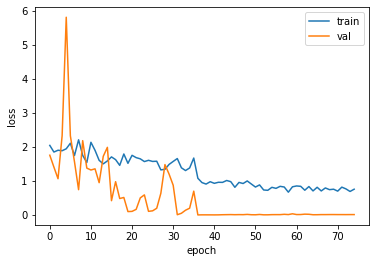

In [ ]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

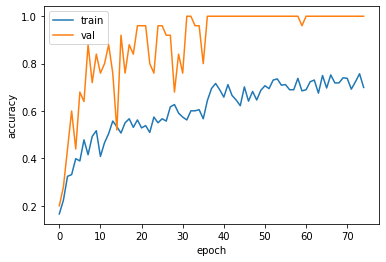

In [ ]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

# Confusion matrix

In [ ]:
def confusion_matrix(model, val_iterator):
    model.eval()
    confusion = torch.zeros(5,5)

    with torch.no_grad():

        for x_batch, y_batch in val_iterator:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
 
            logits = model(x_batch)

            predict = torch.argmax(logits, dim=1, keepdim=True)
            # compute logloss
            ax = torch.cat((y_batch.reshape(-1,1), predict), dim=1)

            for i in range(ax.size(0)):
              confusion[ax[i][1]][ax[i][0]] = confusion[ax[i][1]][ax[i][0]]+1
    return confusion




In [ ]:
confusion = confusion_matrix(model, test_loader)
confusion

tensor([[35.,  0.,  0.,  0.,  2.],
        [ 0., 33.,  0.,  0.,  4.],
        [ 0.,  0., 35.,  0.,  0.],
        [ 0.,  0.,  0., 35.,  0.],
        [ 0.,  2.,  0.,  0., 29.]])

In [ ]:
# from openpyxl import Workbook
 
# write_wb = Workbook()
 
# #이름이 있는 시트를 생성
# #write_ws = write_wb.create_sheet('생성시트')
 
# #Sheet1에다 입력
# write_ws = write_wb.active
# confusion = np.array(confusion)
# #행 단위로 추가
# for i in range(len(confusion)):
#   write_ws.append(list(confusion[i]))
 
# #셀 단위로 추가
# write_wb.save('Spectrogram_confusion_matrix.xlsx')